C:\Users\Home\AppData\Local\Temp\ipykernel_15592\3001301086.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
C:\Users\Home\AppData\Local\Temp\ipykernel_15592\3001301086.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  R0 = abs(OLS_beta / eta)
C:\Users\Home\AppData\Local\Temp\ipykernel_15592\3001301086.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  R0 = abs(OLS_beta / eta)
C:\Users\Home\AppData\Local\Temp\ipykernel_15592\3001301086.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  R0 = abs(OLS_beta / eta)
C:\Users\Home\AppData\Local\Temp\ipykernel_15592\3001301086.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  R0 = abs(OLS_beta / eta)


       t    IA     RA       eta        R0  OLS_beta
72  73.0  82.7  114.1  0.021739  1.396181  0.030352
73  74.0  79.4  113.3  0.010304  1.838974  0.018948
74  75.0  73.7  103.6  0.032584  1.266029  0.041253
75  76.0  74.1   99.4  0.044109  1.197040  0.052800
76  77.0  73.7   90.7  0.104103  1.083695  0.112816
..   ...   ...    ...       ...       ...       ...
67   0.0   0.0    0.0  0.026685  1.313151  0.035041
68   0.0   0.0    0.0  0.082487  1.102003  0.090901
69   0.0   0.0    0.0  0.128094  1.066170  0.136570
70   0.0   0.0    0.0  0.036751  1.232153  0.045283
71   0.0   0.0    0.0  0.018563  1.461969  0.027138

[221 rows x 6 columns]


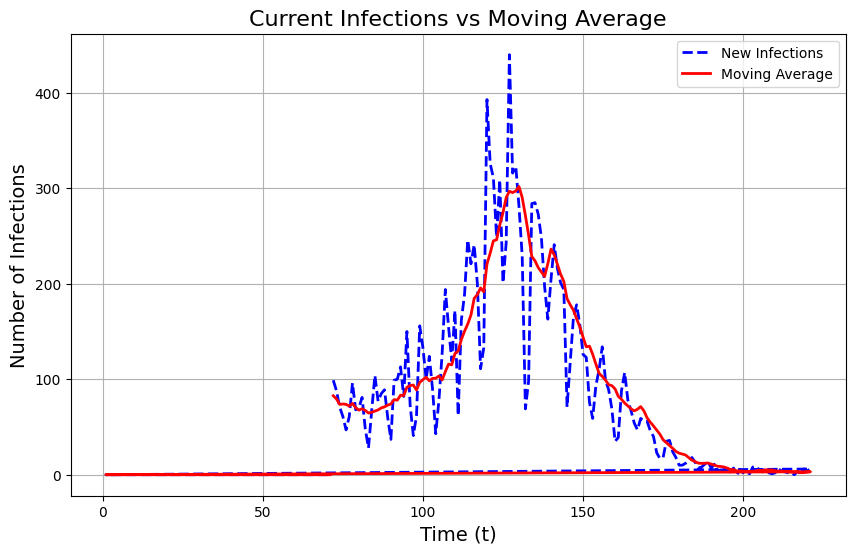

In [2]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt

##### Read the data and fill missing values with 0
df = pd.read_csv('teryt_t3262.csv')  # Replace with the correct file path
df.fillna(0, inplace=True)

##### Set up Dataframe and new columns #####
# Add the two 'new' infection columns 
df['New_I'] = df['Number new infections (entered in system)'] + df['Number of new infections']
# Compute 'R' removed, the sum of recovered and deaths
df['R'] = df['Number of recovered people'] + df['zgony']
# Compute the cumulative infections in a new column
df['total_I'] = df['New_I'].cumsum()
# Compute the current infections in a new column
df['I'] = df['total_I'] - df['R']
# Create a timestep variable
df['t'] = range(1, len(df) + 1)
# Compute the log of infections
df['logI'] = np.log(df['I'].abs())
# Add constant term for intercept
df['intercept'] = 1  

##### Calculate the Moving Averages for 'I' and 'R' #####
window_size = 7  # For a 7-day moving average
df['IA'] = df['New_I'].rolling(window=window_size, min_periods=1).mean().round(1) # Calculate moving average for current infections
df['RA'] = df['R'].rolling(window=window_size, min_periods=1).mean().round(1) # Calculate moving average for removed people

# Define start and end range dates as rows for Feb-Sept 2021
start = 72
end = 222
df= df.iloc[start:end]

##### Estimate parameter k using OLS regression for each row #####
df['k'] = np.nan
df['OLS_beta'] = np.nan
df['R0'] = np.nan
df['eta'] = np.nan

# Loop over each row and compute eta, R0, and OLS parameters based on moving averages
for i in range(1, len(df)):
    # Estimate parameter k using OLS regression for the moving averages
    model = ols('logI ~ t', data=df.iloc[:i + 1]).fit()  # Fit the model up to current row
    k = model.params['t']
    I_0 = model.params['Intercept']
    
    # Estimate η (eta) for each row using moving averages
    eta = abs((df['RA'].iloc[i+1] - df['RA'].iloc[i]) / df['IA'].iloc[i])
    
    # Compute β (OLS_beta) and R₀ (OLS_R0) for each row
    OLS_beta = abs(k + eta)
    R0 = abs(OLS_beta / eta)
    
    # Store the results in the DataFrame
    df.loc[i, 'k'] = k
    df.loc[i, 'OLS_beta'] = OLS_beta
    df.loc[i, 'R0'] = R0
    df.loc[i, 'eta'] = eta
    df.fillna(0, inplace=True)
    
print(df[['t', 'IA', 'RA', 'eta', 'R0', 'OLS_beta']])


plt.figure(figsize=(10, 6))
plt.plot(df['New_I'], label='New Infections', color='blue', linestyle='--', linewidth=2)
plt.plot(df['IA'], label='Moving Average', color='red', linewidth=2)
plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('Number of Infections', fontsize=14)
plt.title('Current Infections vs Moving Average', fontsize=16)
plt.legend()
plt.grid(True)
#plt.show()

#plt.savefig('movingaverage_szczecin.png')
#df.to_csv('movingaverage_dfszczecin.csv', index=False)




